In [193]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline 
data=pd.read_csv("/Users/zhejindong/Downloads/WA_Fn-UseC_-Telco-Customer-Churn.csv")
#data=data.drop(columns=["SalePrice"])

In [194]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
Target=data["Churn"]
data['TotalCharges']=data['TotalCharges'].convert_objects(convert_numeric=True)

# 2.1 
Visualize the univariate distribution of each continuous feature, and the distribution of the
target.

In [195]:
Target=OneHotEncoder().fit_transform(Target.values.reshape(-1,1)).toarray()[:,0]
data_copy=data.drop(columns="Churn")

### Feature distribution

In [197]:
continuous=data_copy.loc[:,data_copy.dtypes!= object]
(continuous.isna()).sum()

SeniorCitizen      0
tenure             0
MonthlyCharges     0
TotalCharges      11
dtype: int64

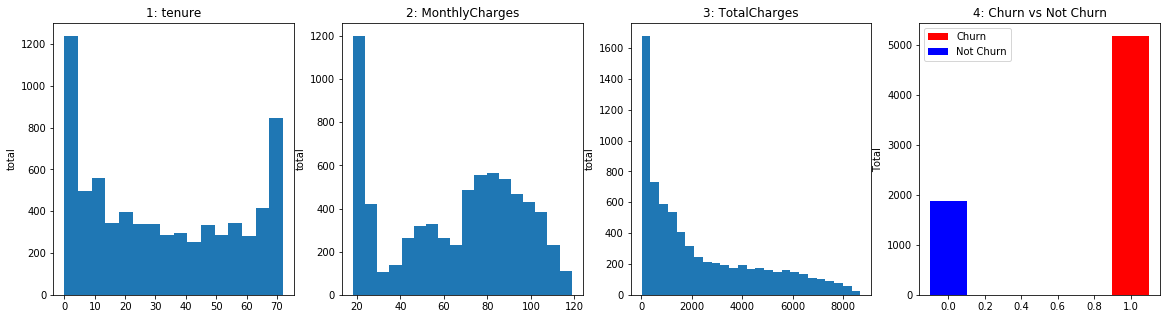

In [198]:
fig, axes = plt.subplots(1,5, figsize=(25, 5))
for i, ax in enumerate(axes.ravel()):
    if i==4:
        ax.set_title("{}: {}".format(i,"Churn vs Not Churn"))
        ax.bar([0,1], [0,sum(Target)],align='center',color="red",label="Churn",width=0.2)
        ax.set_ylabel("Total")
        ax.bar([0,1], [len(Target)-sum(Target),0],align='center',color="blue",label="Not Churn",width=0.2)
        ax.set_ylabel("Total")
        ax.legend()
        continue
    if i==0:
        ax.set_visible(False)
        ax.set_title("{}: {}".format(i,"Senior vs Not Senior"))
        ax.bar([0,1], [0,sum(continuous.iloc[:,i])],align='center',color="red",label="Not Senior",width=0.2)
        ax.set_ylabel("Total")
        ax.bar([0,1], [len(Target)-sum(continuous.iloc[:,i]),0],align='center',color="blue",label="Senior",width=0.2)
        ax.set_ylabel("Total")
        ax.legend()
        continue
    if i==3:
        ax.hist(continuous.iloc[:,i].dropna(), bins="auto")
        ax.set_title("{}: {}".format(i, list(continuous)[i]))
        ax.set_ylabel("total")
        continue
    ax.hist(continuous.iloc[:,i], bins="auto")
    ax.set_title("{}: {}".format(i, list(continuous)[i]))
    ax.set_ylabel("total")

# 2.2 
Split data into training and test set. Build a pipeline for dealing with categorical variables.
Evaluate Logistic Regression, linear support vector machines and nearest centroids using
cross-validation. How different are the results? How does scaling the continuous features with
StandardScaler influence the results?

In [238]:
# Split data into training and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_copy, Target, random_state=0)
#Build a pipeline for dealing with categorical variables
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors.nearest_centroid import NearestCentroid

cat=X_train.dtypes == object

numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='mean'))])
numeric_transformer_std = Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')),
  ('scaler', StandardScaler())])

categorical_features = X_train.dtypes == object
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore',sparse=False))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer,~categorical_features),
        ('cat', categorical_transformer, categorical_features)])

preprocessor_std = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_std,~categorical_features),
        ('cat', categorical_transformer, categorical_features)])

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
print("-------With out standardization--------")
clf_LR = Pipeline(steps=[('preprocessor', preprocessor),
                      ('LogisticRegression',LogisticRegression())])
print("Logistic Regression: %.3f " %np.mean(cross_val_score(clf_LR,X_train, y_train,scoring='f1')))


clf_LSVC = Pipeline(steps=[('preprocessor', preprocessor),
                      ('LinearSVC',LinearSVC())])
print("Linear SVC: %.3f " %np.mean(cross_val_score(clf_LSVC,X_train, y_train,scoring='f1')))


clf_NNC = Pipeline(steps=[('preprocessor', preprocessor),
                      ('NearestCentroid',NearestCentroid())])
print("Nearest Centroid: %.3f " %np.mean(cross_val_score(clf_NNC,X_train, y_train,scoring='f1')))

print("-------With standardization--------")

clf_LR_std = Pipeline(steps=[('preprocessor', preprocessor_std),
                      ('LogisticRegression',LogisticRegression())])
print("Logistic Regression: %.3f " %np.mean(cross_val_score(clf_LR_std,X_train, y_train,scoring='f1')))


clf_LSVC_std = Pipeline(steps=[('preprocessor', preprocessor_std),
                      ('LinearSVC',LinearSVC())])
print("Linear SVC: %.3f " %np.mean(cross_val_score(clf_LSVC_std,X_train, y_train,scoring='f1')))


clf_NNC_std = Pipeline(steps=[('preprocessor', preprocessor_std),
                      ('NearestCentroid',NearestCentroid())])
print("Nearest Centroid: %.3f " %np.mean(cross_val_score(clf_NNC_std,X_train, y_train,scoring='f1')))


-------With out standardization--------
Logistic Regression: 0.868 
Linear SVC: 0.858 
Nearest Centroid: 0.582 
-------With standardization--------
Logistic Regression: 0.870 
Linear SVC: 0.868 
Nearest Centroid: 0.801 


### Answer 

1 Without standardizing data, SVM and Linear regression have higher F1 score, performing much better than Nearest Centroid. This is because Nearest Centroid model is very sensitive to feature scale, and features with large scale will overshadow other features. 

2 Standardizing data does help improve the performance of Nearest centroid model because it fix the scale problem mentioned above. However, it does not benifit the SVM and Logistic Regression too much.

# 2.3 
Tune the parameters using GridSearchCV. Do the results improve?
Visualize the performance as function of the parameters for all three models.

Text(0, 0.5, 'f1')

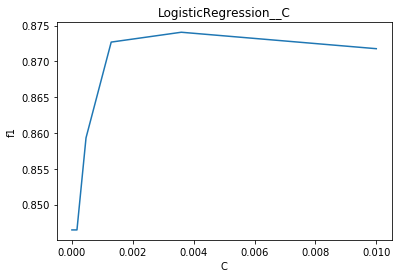

In [253]:
from sklearn.model_selection import GridSearchCV
parameters = {}
param_grid = {'LogisticRegression__C':np.logspace(-6,-2,10)}
CV_LR_std= GridSearchCV(clf_LR_std, param_grid, scoring = 'f1',cv=10)
CV_LR_std.fit(X_train, y_train) 
plt.plot(CV_LR_std.cv_results_["param_LogisticRegression__C"].data, CV_LR_std.cv_results_ ["mean_test_score"])
plt.title("LogisticRegression__C")
plt.xlabel("C")
plt.ylabel("f1")

Text(0, 0.5, 'f1')

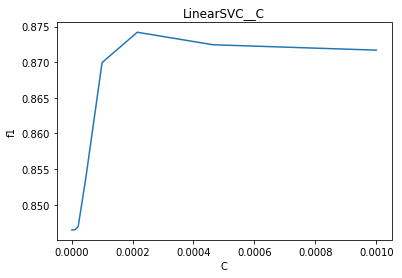

In [234]:
from sklearn.model_selection import GridSearchCV
parameters = {}
param_grid = {'LinearSVC__C': np.logspace(-6,-3,10)}
CV_LSVC_std= GridSearchCV(clf_LSVC_std, param_grid, scoring = 'f1',cv=10)
CV_LSVC_std.fit(X_train, y_train)   
plt.plot(CV_LSVC_std.cv_results_["param_LinearSVC__C"].data, CV_LSVC_std.cv_results_ ["mean_test_score"])
plt.title("LinearSVC__C")
plt.xlabel("C")
plt.ylabel("f1")

Text(0, 0.5, 'f1')

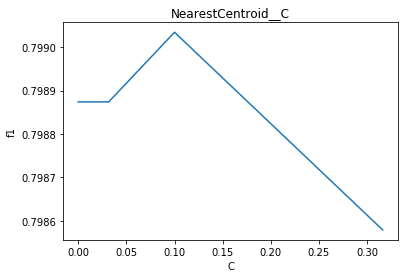

In [286]:
from sklearn.model_selection import GridSearchCV
parameters = {}
param_grid = {'NearestCentroid__shrink_threshold':np.logspace(-5,-0.5,10)}
CV_NNC_std= GridSearchCV(clf_NNC_std, param_grid, scoring = 'f1',cv=10)
CV_NNC_std.fit(X_train, y_train) 
plt.plot(CV_NNC_std.cv_results_["param_NearestCentroid__shrink_threshold"].data, CV_NNC_std.cv_results_ ["mean_test_score"])
plt.title("NearestCentroid__C")
plt.xlabel("C")
plt.ylabel("f1")

## 2.4 
Change the cross-validation strategy from ‘stratified k-fold’ to ‘kfold’ with shuffling. Do the
parameters that are found change? Do they change if you change the random seed of the
shuffling? Or if you change the random state of the split into training and test data?

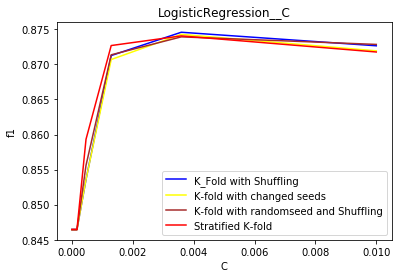

In [306]:
from sklearn.model_selection import KFold
parameters = {}
param_grid = {'LogisticRegression__C':np.logspace(-6,-2,10)}
CV_LR_std_K= GridSearchCV(clf_LR_std, param_grid, scoring = 'f1',cv=KFold(random_state=None, shuffle=True))
CV_LR_std_K.fit(X_train, y_train) 
plt.plot(CV_LR_std_K.cv_results_["param_LogisticRegression__C"].data, CV_LR_std_K.cv_results_ ["mean_test_score"],"blue",label="K_Fold with Shuffling")

CV_LR_std_K_seed= GridSearchCV(clf_LR_std, param_grid, scoring = 'f1',cv=KFold(random_state=1, shuffle=True))
CV_LR_std_K_seed.fit(X_train, y_train) 
plt.plot(CV_LR_std_K_seed.cv_results_["param_LogisticRegression__C"].data, CV_LR_std_K_seed.cv_results_ ["mean_test_score"],"Yellow",label="K-fold with changed seeds")


CV_LR_std_K_split= GridSearchCV(clf_LR_std, param_grid, scoring = 'f1',cv=KFold(random_state=1,n_splits=5, shuffle=True))
CV_LR_std_K_split.fit(X_train, y_train) 
plt.plot(CV_LR_std_K_split.cv_results_["param_LogisticRegression__C"].data,CV_LR_std_K_split.cv_results_ ["mean_test_score"],"brown",label="K-fold with randomseed and Shuffling")


plt.plot(CV_LR_std.cv_results_["param_LogisticRegression__C"].data, CV_LR_std.cv_results_ ["mean_test_score"],"red",label="Stratified K-fold")
plt.title("LogisticRegression__C")
plt.xlabel("C")
plt.ylabel("f1")
plt.legend()

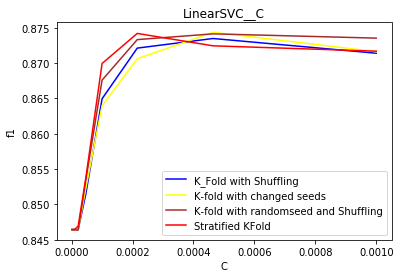

In [316]:
from sklearn.model_selection import KFold
parameters = {}
param_grid = {'LinearSVC__C': np.logspace(-6,-3,10)}
CV_LSVC_std_K= GridSearchCV(clf_LSVC_std, param_grid, scoring = 'f1',cv=KFold(random_state=None, shuffle=True))
CV_LSVC_std_K.fit(X_train, y_train) 
plt.plot(CV_LSVC_std_K.cv_results_["param_LinearSVC__C"].data, CV_LSVC_std_K.cv_results_ ["mean_test_score"],"blue",label="K_Fold with Shuffling")


CV_LSVC_std_K_seed= GridSearchCV(clf_LSVC_std, param_grid, scoring = 'f1',cv=KFold(random_state=1, shuffle=True))
CV_LSVC_std_K_seed.fit(X_train, y_train) 
plt.plot(CV_LSVC_std_K_seed.cv_results_["param_LinearSVC__C"].data, CV_LSVC_std_K_seed.cv_results_ ["mean_test_score"],"Yellow",label="K-fold with changed seeds")


CV_LSVC_std_K_split= GridSearchCV(clf_LSVC_std, param_grid, scoring = 'f1',cv=KFold(random_state=1,n_splits=5, shuffle=True))
CV_LSVC_std_K_split.fit(X_train, y_train) 
plt.plot(CV_LSVC_std_K_split.cv_results_["param_LinearSVC__C"].data,CV_LSVC_std_K_split.cv_results_ ["mean_test_score"],"brown",label="K-fold with randomseed and Shuffling")



plt.plot(CV_LSVC_std.cv_results_["param_LinearSVC__C"].data, CV_LSVC_std.cv_results_ ["mean_test_score"],"red",label="Stratified KFold")
plt.title("LinearSVC__C")
plt.xlabel("C")
plt.ylabel("f1")
plt.legend()

Text(0, 0.5, 'f1')

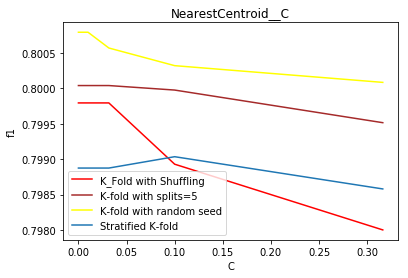

In [304]:
from sklearn.model_selection import GridSearchCV
parameters = {}
param_grid = {'NearestCentroid__shrink_threshold':np.logspace(-5,-0.5,10)}
CV_NNC_std_K= GridSearchCV(clf_NNC_std, param_grid, scoring = 'f1',cv=KFold(random_state=None, shuffle=True))
CV_NNC_std_K.fit(X_train, y_train) 
plt.plot(CV_NNC_std_K.cv_results_["param_NearestCentroid__shrink_threshold"].data, CV_NNC_std_K.cv_results_ ["mean_test_score"],"red",label="K_Fold with Shuffling")


CV_NNC_std_K_split= GridSearchCV(clf_NNC_std, param_grid, scoring = 'f1',cv=KFold(random_state=1,n_splits=5, shuffle=True))
CV_NNC_std_K_split.fit(X_train, y_train) 
plt.plot(CV_NNC_std_K_split.cv_results_["param_NearestCentroid__shrink_threshold"].data,CV_NNC_std_K_split.cv_results_ ["mean_test_score"],"brown",label="K-fold with splits=5")

CV_NNC_std_K_seed= GridSearchCV(clf_NNC_std, param_grid, scoring = 'f1',cv=KFold(random_state=1, shuffle=True))
CV_NNC_std_K_seed.fit(X_train, y_train) 
plt.plot(CV_NNC_std_K_seed.cv_results_["param_NearestCentroid__shrink_threshold"].data,CV_NNC_std_K_seed.cv_results_ ["mean_test_score"],"yellow",label="K-fold with random seed")


plt.plot(CV_NNC_std.cv_results_["param_NearestCentroid__shrink_threshold"].data, CV_NNC_std.cv_results_ ["mean_test_score"],label="Stratified K-fold")
plt.title("NearestCentroid__C")
plt.xlabel("C")
plt.legend()
plt.ylabel("f1")

### Answer:

We use gridsearch to tune the parameter C in the three model, and compared the performance of different cross validation approaches. We found:

1 For Linear SVM and Logistic Regression, KFold and Stratified Kfold will not affect the performance obviously. The lines have similar trends and best C value. 

2 For Near Centroids model, different cross validation methods do matter alot. We notice, using K_fold with changed random can help improve F1 score apparently. 


## 2.5 

Visualize the coefficients for LogisticRegression and Linear Support Vector Machines using
hyper-parameters that performed well in the grid-search.

Text(0.5, 0, 'Features')

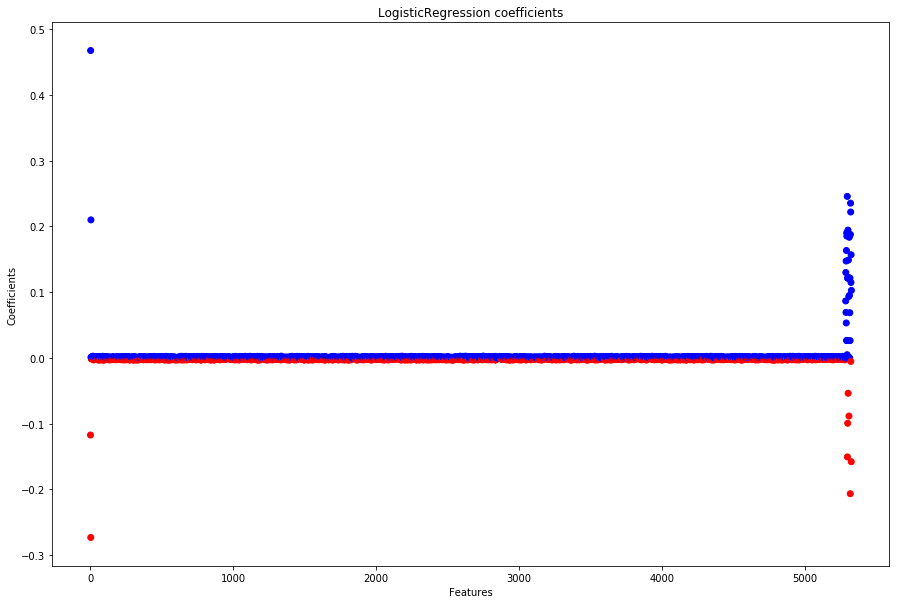

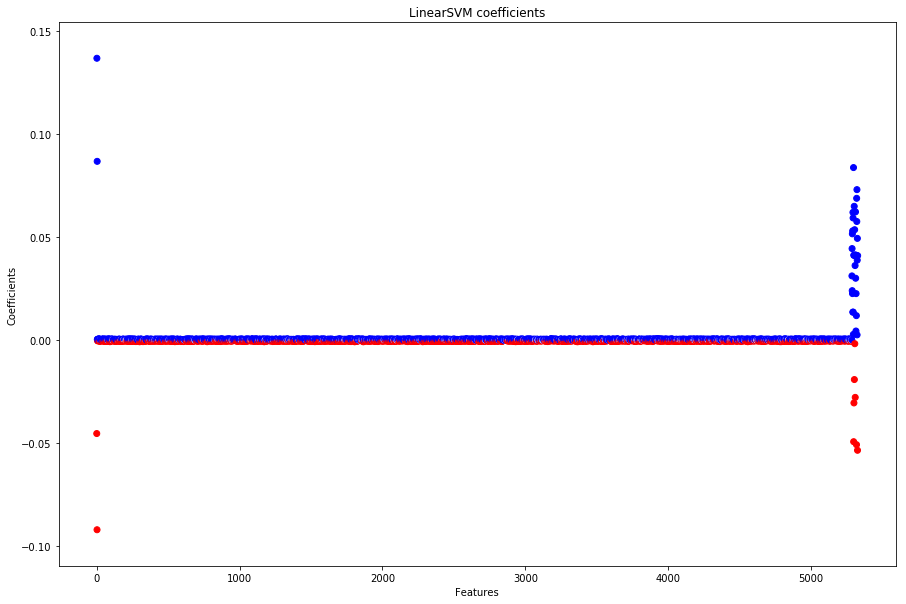

In [360]:
Best_esitmator_coef={}
Best_esitmator_coef["LogisticRegression"]=CV_LR_std_K.best_estimator_.get_params()['LogisticRegression'].coef_
Best_esitmator_coef["LinearSVM"]=CV_LSVC_std.best_estimator_.get_params()['LinearSVC'].coef_

plt.figure(figsize=(15,10))
plt.scatter(range(Best_esitmator_coef["LogisticRegression"].shape[1]),Best_esitmator_coef["LogisticRegression"].reshape(-1,1),c=np.sign(Best_esitmator_coef["LogisticRegression"].reshape(-1,1)),cmap="bwr_r")
plt.title("LogisticRegression coefficients")
plt.ylabel("Coefficients")
plt.xlabel("Features")

plt.figure(figsize=(15,10))
plt.scatter(range(Best_esitmator_coef["LinearSVM"].shape[1]),Best_esitmator_coef["LinearSVM"].reshape(-1,1),c=np.sign(Best_esitmator_coef["LinearSVM"].reshape(-1,1)),cmap="bwr_r")
plt.title("LinearSVM coefficients")
plt.ylabel("Coefficients")
plt.xlabel("Features")
